In [1]:
import locale
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
from tolerance.confidence import ConfidenceCalculator

In [2]:
# Установка параметров шрифта
locale.setlocale(locale.LC_NUMERIC, "de_DE")
plt.rcParams['axes.formatter.use_locale'] = True

font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 14}

matplotlib.rc('font', **font)

Расчет зависимости доверительной вероятности от доли накрытия и толерантных коэффициентов

In [11]:
# Массивы значений толерантных коэффициентов
k1 = np.linspace(0.05, 10, 100, dtype=np.float64)
k2 = np.copy(k1)
# Размер выборки
ss = 100
# Число повторений (статистика счета)
rn = 10000
# Предполагаемое распределение СВ
distr = stats.norm

# Инициализация калькулятора
calculator = ConfidenceCalculator(distr)
# Вычисление истинной доли накрытия rn-ое число раз
calculator.calc_coverages(sample_size=ss, num_of_events=rn, tolerance_factor_lower=k1, tolerance_factor_upper=k2)

In [12]:
# Массив значений доли накрытия для которых вычисляется доверительная вероятность
check_coverages = np.linspace(0, 1, 101)
# Вычисление доверительной вероятности события A[i] = {check_coverages[i] >= true_coverages[i]}
calculator.calc_confidence(check_coverages)

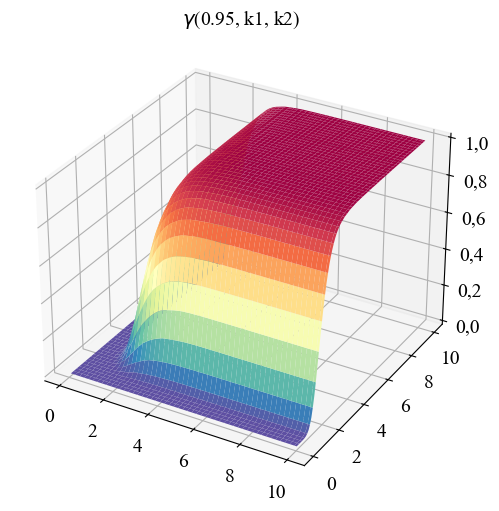

In [5]:
# Отображение результата счета gamma(check_coverage[i], k1, k2)
# Значение доли накрытия
cov = 0.95
# Индекс ближайшего значения к cov
index = np.argmin(np.abs(check_coverages - cov))

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': '3d'})
ax.plot_surface(calculator.K1, calculator.K2, calculator.pair[1][index], cmap=cm.Spectral_r)
ax.set_title(f'$\gamma$({np.round(check_coverages[index], 3)}, k1, k2)', fontsize=14);

Применение вычисленной зависимости для обработки статистических наблюдений

In [6]:
# Вероятность принятия ложного решения
beta = 0.05
# Вероятность принятия верного решения
alpha = 1.0 - beta

# Граница двустороннего интервала
bound = 1
# loc + xp * scale = bound
xp = distr.ppf((alpha + 1) / 2)

# Параметры распределения
loc = 0
scale = (bound - loc) / xp

# Область определения СВ
xmin = -3
xmax = -1 * xmin
xnum = 1001
xx = np.linspace(xmin, xmax, xnum)

In [13]:
def one_plot_true(loc, scale, distr, lb, rb):
    fig, ax = plt.subplots(figsize=(9, 6))
    p1 = ax.plot(xx, distr(loc, scale).pdf(xx), color='r', lw=1)
    ax.fill_between(xx, distr(loc, scale).pdf(xx),
                    where=(xx > lb) & (xx < rb),
                    color='pink', alpha=1.0)

    p2 = ax.plot([lb, lb], [0, 0.8], lw=1, color='k')
    p3 = ax.plot([rb, rb], [0, 0.8], lw=1, color='k')
    pvalue = np.round(distr(loc, scale).cdf(rb) - distr(loc, scale).cdf(lb), 3)
    ax.set_title(f'$P(X \subset [{lb}, {rb}])=\int f(x) dx={pvalue}$', fontsize=14);
    ax.set(ylim=(-0.05, 0.85))
    return p1, p2, p3


def one_plot_estim(loc, scale, distr, lb, rb):
    sample = distr(loc, scale).rvs(ss)
    loc_estim, scale_estim = distr.fit(sample)
    estimated_distr = distr(loc_estim, scale_estim)

    fig, ax = plt.subplots(figsize=(9, 6))
    p1 = ax.plot(xx, distr(loc, scale).pdf(xx), color='r', lw=1)
    p2 = ax.plot([lb, lb], [0, 0.8], lw=1, color='k')
    p3 = ax.plot([rb, rb], [0, 0.8], lw=1, color='k')

    p4 = ax.plot(xx, estimated_distr.pdf(xx), color='b', lw=1)
    ax.fill_between(xx, estimated_distr.pdf(xx),
                    where=(xx > lb) & (xx < rb),
                    color='b', alpha=0.05)

    pvalue = np.round(estimated_distr.cdf(rb) - estimated_distr.cdf(lb), 3)
    ax.set_title(f'$P(X \subset [{lb}, {rb}])=\int  f(x)dx={pvalue}$', fontsize=14);
    p5 = ax.plot(sample, [0] * ss, lw=0, marker='s', mec='b', mfc='w', mew=0.75)
    ax.set(ylim=(-0.05, 0.85))
    return p1, p2, p3, p4, p5

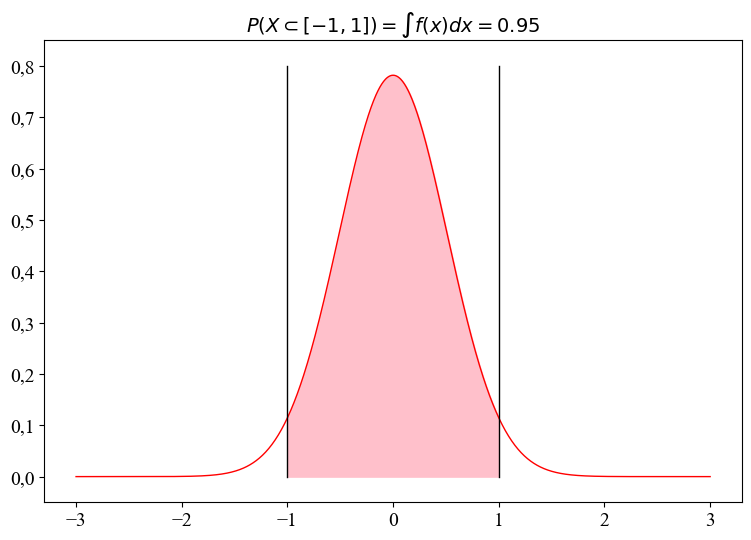

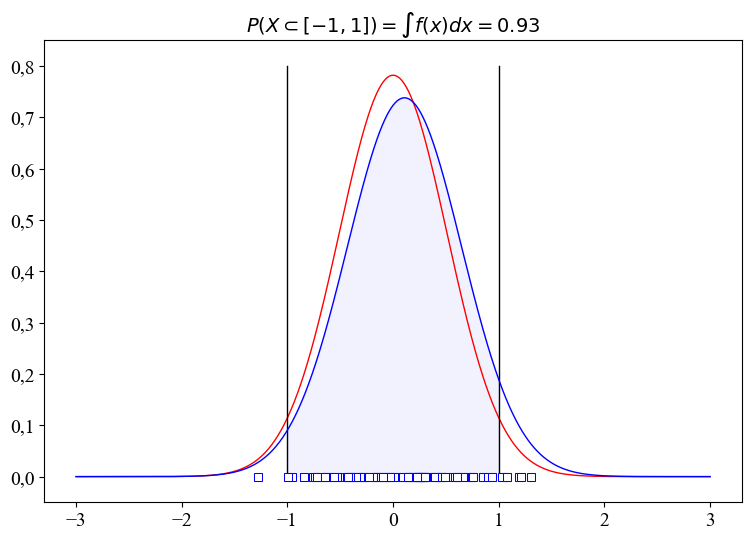

In [36]:
one_plot_true(loc, scale, distr, lb=-1, rb=1)
one_plot_estim(loc, scale, distr, lb=-1, rb=1);

In [22]:
# def update(frame):
#     ax.clear()
#     lb = -1
#     rb = 1
#     sample = distr(loc, scale).rvs(ss)
#     loc_estim, scale_estim = distr.fit(sample)
#     estimated_distr = distr(loc_estim, scale_estim)

#     p1 = ax.plot(xx, distr(loc, scale).pdf(xx), color='r', lw=1)
#     p2 = ax.plot([lb, lb], [0, 0.8], lw=1, color='k')
#     p3 = ax.plot([rb, rb], [0, 0.8], lw=1, color='k')

#     p4 = ax.plot(xx, estimated_distr.pdf(xx), color='b', lw=1)
#     ax.fill_between(xx, estimated_distr.pdf(xx),
#                     where=(xx > lb) & (xx < rb),
#                     color='b', alpha=0.05)

#     pvalue = np.round(estimated_distr.cdf(rb) - estimated_distr.cdf(lb), 3)
#     ax.set_title(f'$P(X \subset [{lb}, {rb}])=\int  f(x)dx={pvalue}$', fontsize=14);
#     p5 = ax.plot(sample, [0] * ss, lw=0, marker='s', mec='b', mfc='w', mew=0.75)
#     ax.set(ylim=(-0.05, 0.85))
#     return p1, p2, p3, p4, p5

# fig, ax = plt.subplots(figsize=(9, 6))
# update(0)
# fn = 21

# ani = animation.FuncAnimation(fig=fig, func=update, frames=fn, interval=200)
# ani.save('anim.gif', writer='pillow') 

In [85]:
# Задается доверительная вероятность
gamma = 0.9

# Выборка случайных чисел
s = stats.norm(loc=0, scale=0.51).rvs(ss)
# Оценка вероятности принятия ложного решения
# с доверительной вероятностью conf
p = calculator.estimate(s, gamma, -1, 1)
q = 1 - p
print(q)

0.040000000000000036


100%*gamma всех оценок вероятности ошибки не меньше истинного значения вероятности ошибки beta

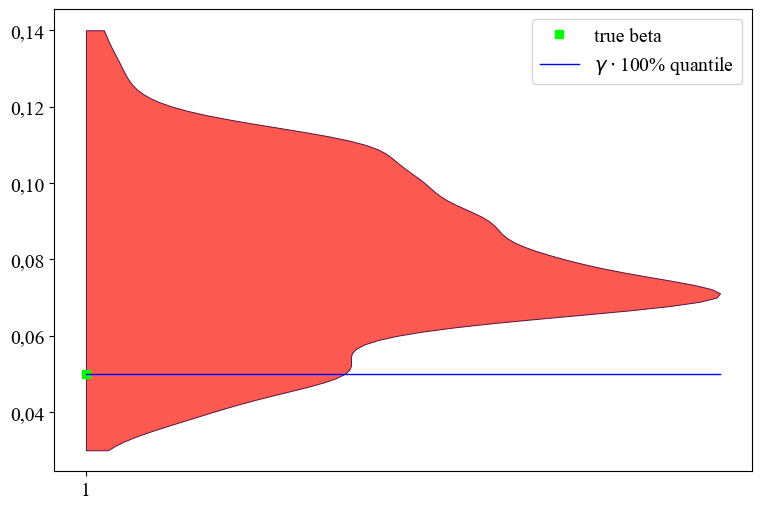

In [86]:
# Многократное повторения процедуры нахождения оценки вероятности
# принятия ложного решения. Итог - распределение значений оценок
# Черная линия - gamma*100%-ый квантиль распределения

n = 1000
E = np.empty(n)
for i in range(n):
    s = stats.norm(loc=0, scale=0.51).rvs(ss)
    E[i] = 1 - calculator.estimate(s, gamma, -1, 1)

qu = np.quantile(E, 0.1)
fig, ax = plt.subplots(figsize=(9, 6))
parts = ax.violinplot(E, showextrema=False, side='high')

for pc in parts['bodies']:
    pc.set_facecolor('#FC5A50')
    pc.set_edgecolor('#580F41')
    pc.set_linewidth(0.7)
    pc.set_alpha(1.0)


# for partname in (['cquantiles']):
#     vp = parts[partname]
#     vp.set_edgecolor('k')
#     vp.set_linewidth(1.0)

ax.set_xticks([1.0]);
ax.plot(1, beta, lw=0, marker='s', color='#00FF00', label='true beta')
ax.plot([1, 1.25], [qu, qu], lw=1, color='b', label='$\gamma \cdot$100% quantile')
ax.legend(loc=0)